In [43]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras import optimizers
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model


In [44]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [45]:
def NN_discriminator(inputs,kernel_size):
    #kernel_size: length of CNN window
    #input: image
    nfilter_layers=[16,32,64,128]
    x=inputs
    for nfilter in nfilter_layers:
        stride=2
        if nfilter==nfilter_layers[-1]:
            stride=1
        x=LeakyReLU(alpha=0.2)(x)
        x=Conv2D(filters=nfilter,kernel_size=kernel_size,strides=stride,padding='same')(x)
    x=Flatten()(x)
    x=Dense(1)(x)
    x=Activation('sigmoid')(x)
    discriminator=Model(inputs,x,name='Discriminator')
    return discriminator

In [46]:
def NN_generator(inputs,size_imag,kernel_size):
    nfilter_layers=[64,32,16,1]
    imag_resize=size_imag//4
    x=Dense(imag_resize*imag_resize*nfilter_layers[0])(inputs)
    x=Reshape((imag_resize,imag_resize,nfilter_layers[0]))(x)
    
    for nfilter in nfilter_layers:
        stride=2
        if nfilter>nfilter_layers[-2]:
            stride=1
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        x=Conv2DTranspose(filters=nfilter,kernel_size=kernel_size,strides=stride,padding='same')(x)
    x=Activation('sigmoid')(x)
    generator=Model(inputs,x,name='Generator')
    return generator

In [47]:
def plot_imag(generator,noise_input,show=False,step=0,model_name='gan'):
    """
    generator(model)
    noise_input(ndarray): array of latent vector
    """
    os.makedirs(model_name,exist_ok=True)
    filename=os.path.join(model_name,"%3d.png" %step)
    imags=generator.predict(noise_input)
    plt.figure(figsize=(10,10))
    n_imag=imags.shape[0]
    size_imag=imags.shape[1]
    cols=4
    rows=int(noise_input.shape[0]/cols)
    for i in range(n_imag):
        plt.subplot(rows,cols,i+1)
        imag=np.reshape(imags[i],[size_imag,size_imag])
        plt.imshow(imag,cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')
    

In [48]:
def train_GAN(models,x_train,param):
    generator,discrim,gan=models
    batch_size, dim_latent, train_steps = param
    save_interval=1000
    noise=np.random.uniform(-1.0,1.0,size=[16,dim_latent])
    train_size=x_train.shape[0]
    for i in range(train_steps):
        id_rand=np.random.randint(0,train_size,size=batch_size)
        imag_real=x_train[id_rand]
        noise_input=np.random.uniform(-1.0,1.0,size=[batch_size,dim_latent])
        imag_fake=generator.predict(noise_input)
        x=np.concatenate((imag_real,imag_fake))
        y=np.ones([2*batch_size,1])
        y[batch_size:,:]=0.0
        loss,acc=discrim.train_on_batch(x,y)
        if i>=100 and i%100==0:
            log="%d:discrim loss: %f, acc: %f" %(i,loss,acc)
        
        noise=np.random.uniform(-1.0,1.0,size=[batch_size,dim_latent])
        y=np.ones([batch_size,1])
        loss,acc=gan.train_on_batch(noise,y)
        if i>=100 and i%100==0:
            log="%s; gan loss: %f, acc: %f" %(log,loss,acc)
            print(log)
        if(i+1)% save_interval==0:
            if (i+1)==train_steps:
                show_flag=True
            else:
                show_flag=False    
            plot_imag(generator,noise_input=noise_input,show=show_flag,step=(i+1),model_name='GAN')      
    generator.save("gan_mnist.h5")  
        

In [49]:
def build_GAN():
    (x_train,_),(_,_)=mnist.load_data()
    size_imag=x_train.shape[1]
    x_train=np.reshape(x_train,[-1,size_imag,size_imag,1])
    x_train=x_train.astype('float32')/255
    
    dim_latent=25
    batch_size=64
    train_steps=10000
    lr=2e-4
    decay_rate = 1e-7
    
    #build discriminator model
    input_shape=(size_imag,size_imag,1)
    input_discrim=Input(shape=input_shape,name='input_discrim')
    kernel_size_discrim=5
    discrim=NN_discriminator(input_discrim,kernel_size_discrim)
    optimizer=optimizers.Adam(lr=lr,decay=decay_rate)
    discrim.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    discrim.summary()
    
    #build generator model
    kernel_size_gen=5
    input_shape=(dim_latent,)
    input_gen=Input(shape=input_shape,name='latent_input')
    generator=NN_generator(input_gen,size_imag,kernel_size_gen)
    #generator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    generator.summary()
    
    optimizer=optimizers.Adam(lr=lr,decay=decay_rate*0.5)
    discrim.trainable = False
    gan=Model(input_gen,discrim(generator(input_gen)),name='gan')
    gan.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    gan.summary()
    
    models=(generator,discrim,gan)
    param=(batch_size,dim_latent,train_steps)
    train_GAN(models,x_train,param)

In [50]:
def test_generator(generator):
    noise_input=np.random.uniform(-1.0,1.0,size=[16,20])
    plot_imag(generator,noise_input,show=True,model_name='test_generator')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_discrim (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        416       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          12832     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 32)          0      

/Users/Bluesky/anaconda/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100:discrim loss: 0.000439, acc: 1.000000; gan loss: 0.100005, acc: 1.000000
200:discrim loss: 0.001729, acc: 1.000000; gan loss: 0.696779, acc: 0.375000
300:discrim loss: 0.014209, acc: 1.000000; gan loss: 3.092068, acc: 0.000000
400:discrim loss: 0.007476, acc: 1.000000; gan loss: 7.595908, acc: 0.000000
500:discrim loss: 0.005103, acc: 1.000000; gan loss: 10.841255, acc: 0.000000
600:discrim loss: 0.010750, acc: 0.992188; gan loss: 10.799322, acc: 0.000000
700:discrim loss: 0.016669, acc: 0.992188; gan loss: 7.734886, acc: 0.000000
800:discrim loss: 0.066661, acc: 0.984375; gan loss: 0.278635, acc: 0.921875
900:discrim loss: 0.033316, acc: 0.984375; gan loss: 2.809544, acc: 0.000000
1000:discrim loss: 0.096303, acc: 0.984375; gan loss: 6.335379, acc: 0.000000
1100:discrim loss: 0.135610, acc: 0.968750; gan loss: 7.742282, acc: 0.000000
1200:discrim loss: 0.056056, acc: 0.992188; gan loss: 6.527595, acc: 0.000000
1300:discrim loss: 0.007882, acc: 1.000000; gan loss: 6.837227, acc: 0.

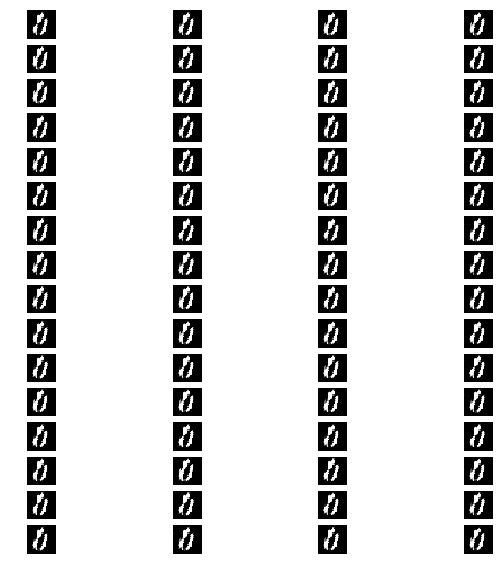

In [51]:
build_GAN()

In [58]:
generator = load_model('gan_mnist.h5')



SyntaxError: invalid character in identifier (<ipython-input-57-7be644392e35>, line 1)

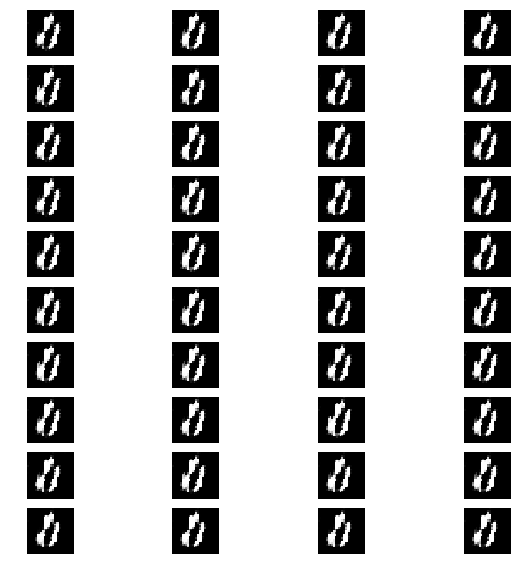

In [62]:
#output some images generated by generator, with input as random noise
noise_input=np.random.uniform(-1.0,1.0,size=[40,25])
plot_imag(generator,noise_input,show=True,model_name='test_generator')